In [ ]:
!python -m pip install pillow numpy pytesseract pytorch-lightning scikit-learn torchvision Unidecode

In [1]:
import pytorch_lightning as pl
from pathlib import Path
import torch
import re
from torchvision import transforms
from PIL import Image, ImageDraw
import numpy as np
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json
import cv2
import unidecode
import torchvision

In [2]:
import sys
sys.path.append('..')
from ocr_dataset import OCRDataset, get_data_info

## Установка констант и путей

In [3]:
MAX_LEN = 3 * 8
c = 3/8
N = 256
ROOT_DIR = Path("../data/data/")

MAX_LEN - размер выхода бэкбона mobilenet, максимально возможнная длина номера

N, c - размер входного изображения

data - датасет с kaggle, который скинул Юра

In [4]:
data_info = json.load((ROOT_DIR / "train.json").open("r"))
ignore_list = ["train/25632.bmp"] # сломанный файл
data_info = [x for x in data_info if x["file"] not in ignore_list]

data_info = get_data_info(ROOT_DIR / "train.json")
train_data, val_data = train_test_split(data_info, test_size=0.2)

In [5]:
number_regex = re.compile(r"([ABEKMHOPCTYX]\d{3}[ABEKMHOPCTYX]{2}) (\d+)")
symbols = set([' '])
for item in data_info:
    for num in item["nums"]:
        symbols = symbols | set(unidecode.unidecode(num["text"].upper()))
symbols = list(symbols)
S = len(symbols)
symbols_encoder = LabelEncoder()
symbols_encoder.fit(symbols)

LabelEncoder()

Приведение номеров к единому виду.

In [6]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomPerspective(distortion_scale=0.6, p=0.3),
    transforms.RandomRotation(degrees=(0, 10)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
class LitAutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.features = torchvision.models.mobilenet_v3_small().features#torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=False).features
        self.conv = nn.Conv2d(576, 256, kernel_size=1)
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, batch_first=True)
        self.linear = nn.Linear(256, S)

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = x.reshape((x.shape[0], x.shape[2]*x.shape[3], x.shape[1]))
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, number = batch
        pred_number = self(x)
        
        loss = 0.0
        for i in range(MAX_LEN):
            item = pred_number[:, i]
            loss = loss + torch.nn.functional.cross_entropy(item, number[:, i])
        loss /= MAX_LEN
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, number = batch
        pred_number = self(x)
        
        loss = 0.0
        for i in range(MAX_LEN):
            item = pred_number[:, i]
            loss = loss + torch.nn.functional.cross_entropy(item, number[:, i])
        loss /= MAX_LEN
        # Logging to TensorBoard by default
        self.log("val_loss", loss)

        acc = []
        for i in range(MAX_LEN):
            item = pred_number[:, i].argmax(axis=1)
            acc_item = item == number[:, i]
            acc.extend(list(acc_item.cpu().detach().numpy().flatten()))
        acc = np.mean(acc)
        self.log("val_acc", acc)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [9]:
train_dataset = OCRDataset(ROOT_DIR, train_data, train_transform, symbols_encoder)
val_dataset = OCRDataset(ROOT_DIR, val_data, transform, symbols_encoder)

In [10]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, num_workers=4, batch_size=256)
val_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle=False, num_workers=4, batch_size=256)

In [ ]:
# a, _ = next(iter(train_dataloader))

In [32]:
model = LitAutoEncoder()

In [33]:
# model

In [ ]:
trainer = pl.Trainer(max_epochs=100, accelerator='gpu', devices=1, default_root_dir="../logs")
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

In [35]:
model.eval()

LitAutoEncoder(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, trac

In [111]:
A = torch.load("../logs/lightning_logs/version_11/checkpoints/epoch=66-step=5627.ckpt")

In [113]:
torch.save(A["state_dict"], "../model.pt")

In [93]:
with torch.no_grad():
    a = val_dataset[11]
    res = model(a[0].unsqueeze(0))

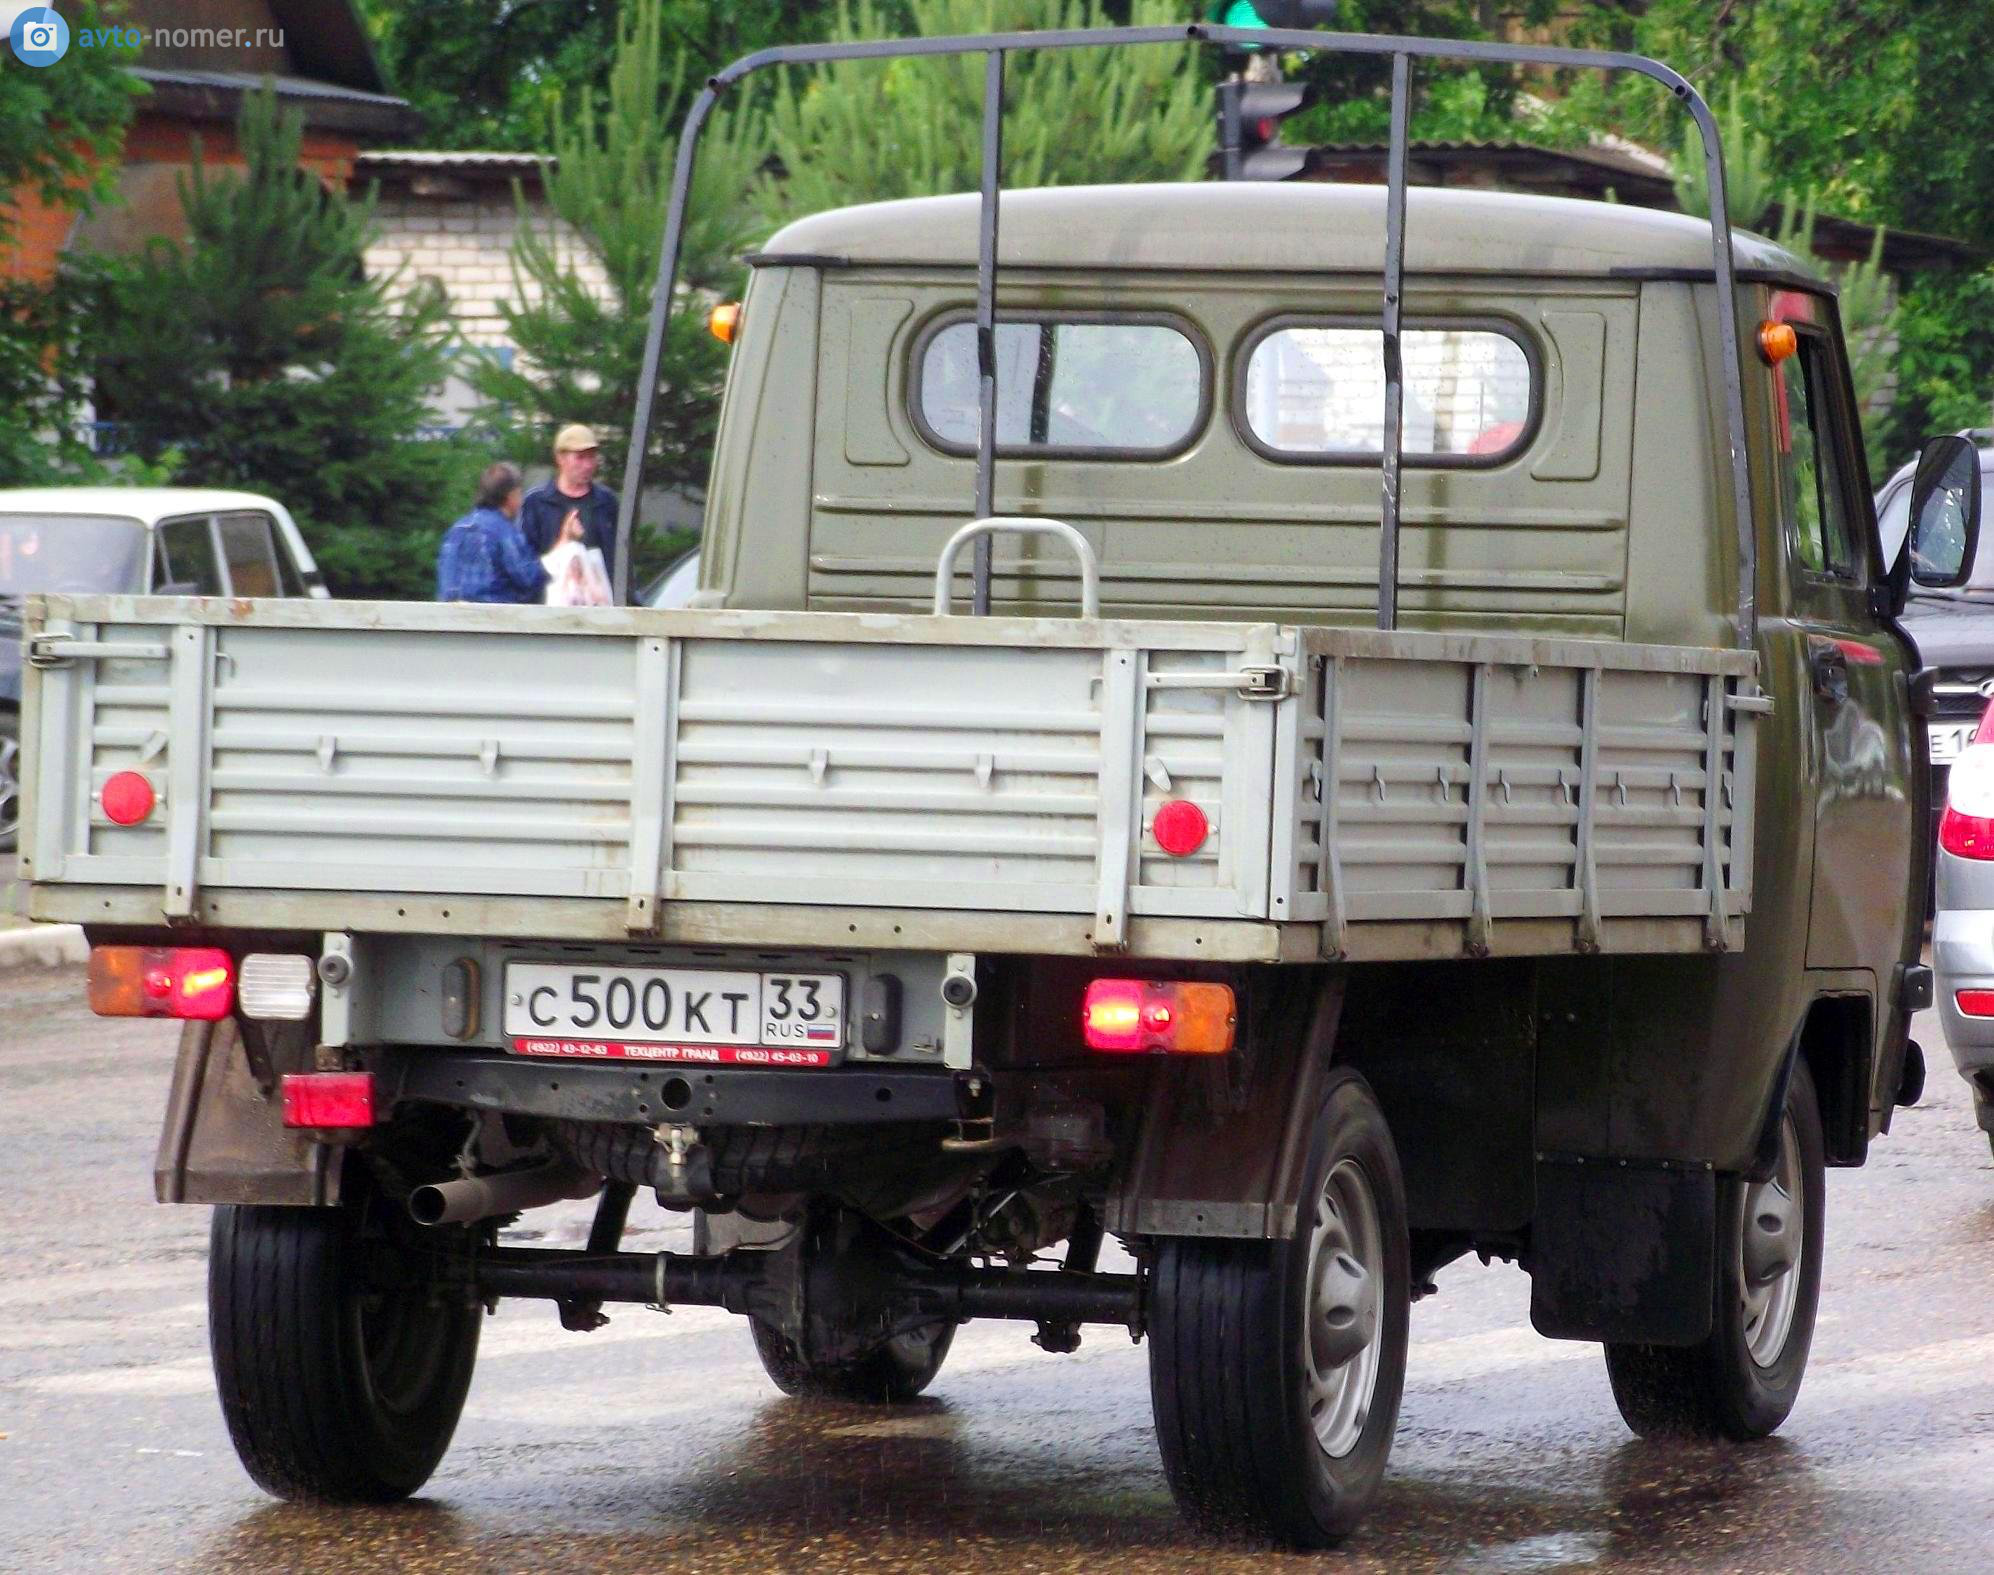

In [94]:
Image.open(ROOT_DIR / val_dataset.nums[11]["file"])

In [95]:
res_symb = symbols_encoder.inverse_transform(res[0].argmax(axis=1).cpu().numpy().tolist())
"".join(res_symb).strip()

'C500KT33'

In [106]:
val_dataset.nums[11]

{'file': 'train/22677.jpg',
 'box': [[506, 964], [842, 977], [840, 1048], [504, 1034]],
 'text': 'C500KT33'}